In [91]:
# Load libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


## Loading the Data

In [92]:
# load dataset
loans = pd.read_csv('LoansData_sample.csv.gz', compression='gzip', encoding='utf-8')
#loans = pd.read_csv('LoansData.csv.gz', compression='gzip', low_memory=True) #Use this for the actual data

In [93]:
dataset = loans

In [94]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [95]:
dataset.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,0,38098114,NaN,15000.0,15000.0,15000.0,60 months,12.39,336.64,C,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,1,36805548,NaN,10400.0,10400.0,10400.0,36 months,6.99,321.08,A,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,2,37842129,NaN,21425.0,21425.0,21425.0,60 months,15.59,516.36,D,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,3,37612354,NaN,12800.0,12800.0,12800.0,60 months,17.14,319.08,D,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,4,37662224,NaN,7650.0,7650.0,7650.0,36 months,13.66,260.20,C,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


## Data Preparation and Feature Selection

In [96]:
# We're going to try to predict the loan_status variable. What are the value counts for this variable
dataset['loan_status'].value_counts(dropna=False)

Fully Paid            69982
Charged Off           16156
Current               12726
Late (31-120 days)      730
In Grace Period         264
Late (16-30 days)       139
Default                   3
Name: loan_status, dtype: int64

In [97]:
dataset = dataset.loc[dataset['loan_status'].isin(['Fully Paid', 'Charged Off'])]

dataset['loan_status'].value_counts(dropna=False)

dataset['loan_status'].value_counts(normalize=True, dropna=False)

Fully Paid     0.812441
Charged Off    0.187559
Name: loan_status, dtype: float64

In [98]:
dataset['charged_off'] = (dataset['loan_status'] == 'Charged Off').apply(np.uint8)
dataset.drop('loan_status', axis=1, inplace=True)

1. Eliminate feature that have more than 30% missing values.
2. Eliminate features that are unintuitive based on subjective judgement.
3. Eliminate features with low correlation with the predicted variable

In [99]:
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)

missing_fractions.head(10)

total_cu_tl                            1.0
annual_inc_joint                       1.0
sec_app_mths_since_last_major_derog    1.0
sec_app_collections_12_mths_ex_med     1.0
sec_app_chargeoff_within_12_mths       1.0
open_rv_12m                            1.0
sec_app_num_rev_accts                  1.0
sec_app_open_act_il                    1.0
sec_app_revol_util                     1.0
sec_app_open_acc                       1.0
dtype: float64

In [100]:
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
print(drop_list)

['all_util', 'annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'member_id', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_ma

In [101]:
len(drop_list)

58

In [102]:
dataset.drop(labels=drop_list, axis=1, inplace=True)
dataset.shape

(86138, 93)

## Features elimination based on the intutiveness

In [103]:
print(sorted(dataset.columns))

['Unnamed: 0', 'acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'charged_off', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'id', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_

In [104]:
keep_list = ['charged_off','funded_amnt','addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code','last_pymnt_amnt','num_actv_rev_tl', 'mo_sin_rcnt_rev_tl_op','mo_sin_old_rev_tl_op',"bc_util","bc_open_to_buy","avg_cur_bal","acc_open_past_24mths" ]

len(keep_list)

40

In [105]:
drop_list = [col for col in dataset.columns if col not in keep_list]

dataset.drop(labels=drop_list, axis=1, inplace=True)

dataset.shape

(86138, 39)

## Features elimination based on the correlation

In [106]:
correlation = dataset.corr()
correlation_chargeOff = abs(correlation['charged_off'])

In [107]:
correlation_chargeOff.sort_values(ascending=False)

charged_off              1.000000
last_pymnt_amnt          0.319081
int_rate                 0.282825
dti                      0.123108
fico_range_low           0.121892
fico_range_high          0.121891
acc_open_past_24mths     0.105989
bc_open_to_buy           0.080077
bc_util                  0.077744
avg_cur_bal              0.071977
num_actv_rev_tl          0.071185
revol_util               0.066188
loan_amnt                0.060818
funded_amnt              0.060818
mort_acc                 0.057858
annual_inc               0.050349
mo_sin_old_rev_tl_op     0.049426
mo_sin_rcnt_rev_tl_op    0.048839
open_acc                 0.039430
installment              0.032847
revol_bal                0.021714
pub_rec                  0.016023
pub_rec_bankruptcies     0.015815
total_acc                0.005804
id                       0.002221
Name: charged_off, dtype: float64

<Axes: >

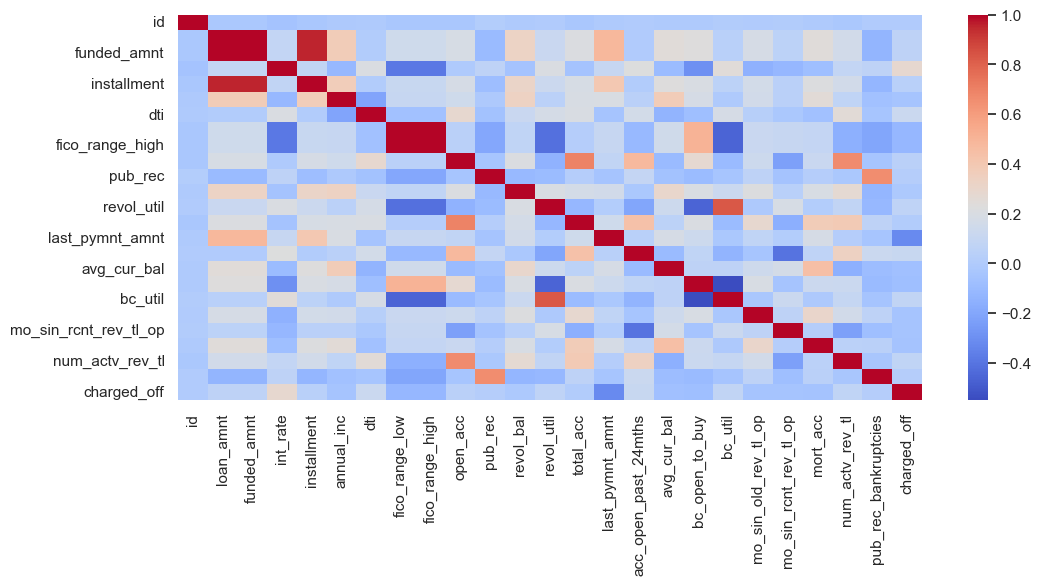

In [108]:

sns.heatmap(correlation, cmap="coolwarm")

In [109]:
drop_list_corr = sorted(list(correlation_chargeOff[correlation_chargeOff < 0.03].index))
print(drop_list_corr)

['id', 'pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 'total_acc']


In [110]:
dataset.drop(labels=drop_list_corr, axis=1, inplace=True)
dataset.shape

(86138, 34)

## Feature Engineering and Exploratory Analysis

In [111]:
#Descriptive Statistics
dataset.describe()

,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,open_acc,revol_util,last_pymnt_amnt,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,charged_off
count,86138.000000,86138.000000,86138.000000,86138.000000,8.613800e+04,86138.000000,86138.000000,86138.000000,86138.000000,86094.000000,86138.000000,86138.000000,86138.000000,85142.000000,85089.000000,86138.000000,86138.000000,86138.000000,86138.000000,86138.000000
mean,14106.526446,14106.526446,13.002360,430.737187,7.384311e+04,18.532747,692.462966,696.463024,11.746453,54.582777,4757.453184,4.594732,13066.638371,8942.506507,63.808959,183.524333,12.796896,1.748880,5.762358,0.187559
std,8391.139221,8391.139221,4.397419,251.653139,5.929352e+04,8.538247,29.731549,29.731848,5.433122,23.515901,6466.767327,3.070996,16232.739293,14100.186250,27.051347,93.266430,16.224586,2.091488,3.224598,0.390362
min,1000.000000,1000.000000,6.000000,30.420000,4.000000e+03,0.000000,660.000000,664.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,7800.000000,7800.000000,9.490000,248.480000,4.500000e+04,12.070000,670.000000,674.000000,8.000000,37.200000,358.522500,2.000000,3010.000000,1087.000000,44.100000,118.000000,3.000000,0.000000,3.000000,0.000000
50%,12000.000000,12000.000000,12.990000,370.480000,6.247372e+04,17.950000,685.000000,689.000000,11.000000,54.900000,1241.230000,4.000000,6994.500000,3823.000000,67.700000,167.000000,8.000000,1.000000,5.000000,0.000000
75%,20000.000000,20000.000000,15.610000,568.005000,9.000000e+04,24.500000,705.000000,709.000000,14.000000,72.500000,7303.205000,6.000000,17905.000000,10588.000000,87.500000,232.000000,15.000000,3.000000,7.000000,0.000000
max,35000.000000,35000.000000,26.060000,1408.130000,7.500000e+06,39.990000,845.000000,850.000000,84.000000,180.300000,36234.440000,53.000000,447433.000000,249625.000000,255.200000,718.000000,372.000000,34.000000,38.000000,1.000000


### Analysing the categorical features

In [112]:
dataset[['emp_title','title','zip_code']].describe()

,emp_title,title,zip_code
count,81416,86138,86138
unique,32987,20,846
top,Teacher,Debt consolidation,750xx
freq,1576,52990,954


In [113]:
#Ids are all unique and there are too many job titles and titles and zipcode, 
#these column is dropped The ID is not useful for modeling.
dataset.drop(['emp_title','title','zip_code'], axis=1, inplace=True)

Feature - Term

In [114]:
#Convert term to integers
dataset['term'] = dataset['term'].apply(lambda s: np.int8(s.split()[0]))

In [115]:
dataset.groupby('term')['charged_off'].value_counts(normalize=True).loc[:,1]

term
36    0.141526
60    0.354356
Name: charged_off, dtype: float64

Loans with five-year periods are more than twice as likely to charge-off as loans with three-year periods.

Feature- Employement Length

In [116]:
dataset['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)

dataset['emp_length'].replace('< 1 year', '0 years', inplace=True)

def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
    
dataset['emp_length'] = dataset['emp_length'].apply(emp_length_to_int)


<Axes: xlabel='emp_length'>

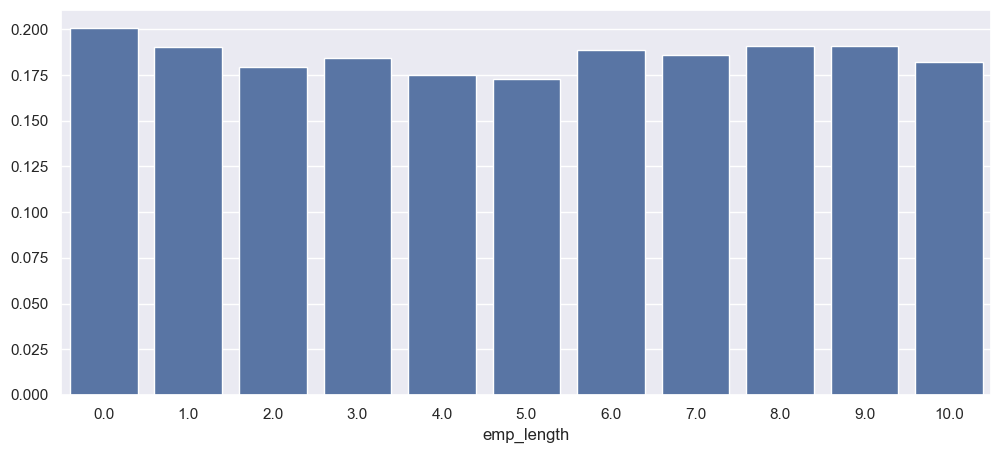

In [117]:
charge_off_rates = dataset.groupby('emp_length')['charged_off'].value_counts(normalize=True).loc[:,1]
sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1)


Loan status does not appear to vary much with employment length on average, hence it is dropped

In [118]:
dataset.drop(['emp_length'], axis=1, inplace=True)

Feature : Subgrade

<Axes: xlabel='sub_grade'>

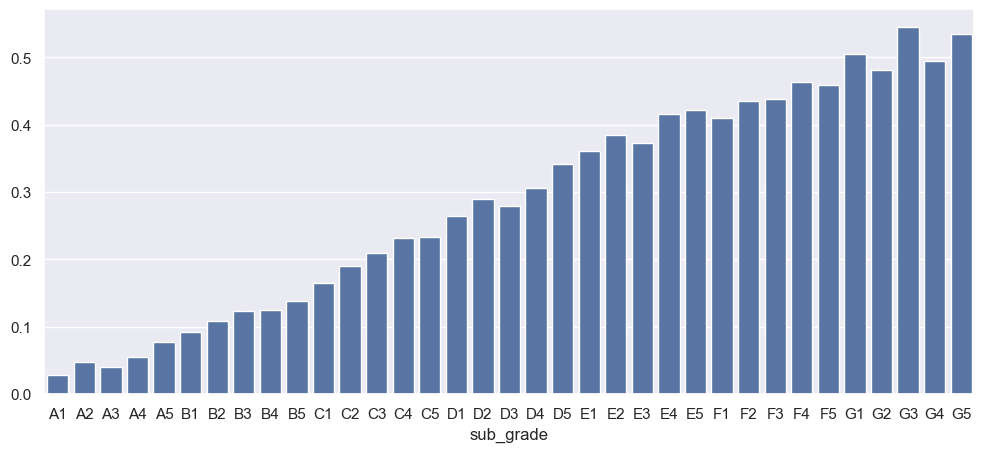

In [119]:
charge_off_rates = dataset.groupby('sub_grade')['charged_off'].value_counts(normalize=True).loc[:,1]
sns.set(rc={'figure.figsize':(12,5)})
sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1)


There's a clear trend of higher probability of charge-off as the subgrade worsens.

Feature - earliest_cr_line

In [120]:
dataset['earliest_cr_line'].head()

0    Aug-1994
1    Sep-1989
2    Aug-2003
4    Aug-2002
5    Nov-1992
Name: earliest_cr_line, dtype: object

In [121]:
dataset['earliest_cr_line'] = dataset['earliest_cr_line'].apply(lambda s: int(s[-4:]))

## Analysing the continuous features

Feature : Annual Income

In [51]:
# Because of the large range of incomes, we should take a log transform of the annual income variable
dataset['log_annual_inc'] = dataset['annual_inc'].apply(lambda x: np.log10(x+1))
dataset.drop('annual_inc', axis=1, inplace=True)

Feature - FICO Scores

In [52]:
dataset[['fico_range_low','fico_range_high']].corr()

,fico_range_low,fico_range_high
fico_range_low,1.0,1.0
fico_range_high,1.0,1.0


Given that the correlation between fico low and high is 1 it is preferred to keep only one feature which is average of FICO Scores

In [53]:
dataset['fico_score'] = 0.5*dataset['fico_range_low'] + 0.5*dataset['fico_range_high']

dataset.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)

## Encoding Categorical Data

In [54]:
from sklearn.preprocessing import LabelEncoder

In [55]:
# Categorical boolean mask
categorical_feature_mask = dataset.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = dataset.columns[categorical_feature_mask].tolist()

In [56]:
categorical_cols

['grade',
 'sub_grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'addr_state',
 'initial_list_status',
 'application_type']

In [57]:
le = LabelEncoder()
# apply le on categorical feature columns
dataset[categorical_cols] = dataset[categorical_cols].apply(lambda col: le.fit_transform(col))
dataset[categorical_cols].head(10)

,grade,sub_grade,home_ownership,verification_status,purpose,addr_state,initial_list_status,application_type
0,2,10,3,1,2,40,1,0
1,0,2,1,0,1,4,1,0
2,3,15,3,1,1,21,1,0
4,2,12,3,1,2,3,0,0
5,2,12,3,1,2,26,0,0
6,1,9,1,1,3,20,0,0
7,1,8,2,2,2,40,1,0
8,2,13,3,1,1,42,0,0
9,1,8,3,0,2,18,0,0
10,1,9,3,2,2,19,0,0


In [58]:
dataset.head(5)

,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,home_ownership,verification_status,purpose,...,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,charged_off,log_annual_inc,fico_score
0,15000.0,15000.0,60,12.39,336.64,2,10,3,1,2,...,29828.0,9525.0,4.7,244.0,1.0,0.0,4.0,0,4.892100,752.0
1,10400.0,10400.0,36,6.99,321.08,0,2,1,0,1,...,9536.0,7599.0,41.5,290.0,1.0,1.0,9.0,1,4.763435,712.0
2,21425.0,21425.0,60,15.59,516.36,3,15,3,1,1,...,4232.0,324.0,97.8,136.0,7.0,0.0,4.0,0,4.804827,687.0
4,7650.0,7650.0,36,13.66,260.20,2,12,3,1,2,...,5857.0,332.0,93.2,148.0,8.0,0.0,4.0,1,4.698979,687.0
5,9600.0,9600.0,36,13.66,326.53,2,12,3,1,2,...,3214.0,6494.0,69.2,265.0,23.0,0.0,7.0,0,4.838855,682.0


In [59]:
dataset.shape

(86138, 29)

## Sampling Data

In [61]:
loanstatus_0 = dataset[dataset["charged_off"]==0]
loanstatus_1 = dataset[dataset["charged_off"]==1]
subset_of_loanstatus_0 = loanstatus_0.sample(n=5500)
subset_of_loanstatus_1 = loanstatus_1.sample(n=5500)
dataset = pd.concat([subset_of_loanstatus_1, subset_of_loanstatus_0])
dataset = dataset.sample(frac=1).reset_index(drop=True)
print("Current shape of dataset :",dataset.shape)
dataset.head()

Current shape of dataset : (11000, 29)


,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,home_ownership,verification_status,purpose,...,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,charged_off,log_annual_inc,fico_score
0,15000.0,15000.0,36,7.12,463.98,0,2,1,0,2,...,2010.0,10445.0,51.2,225.0,10.0,6.0,7.0,0,5.096913,687.0
1,10000.0,10000.0,36,6.03,304.36,0,0,3,0,1,...,2745.0,2285.0,77.4,106.0,26.0,0.0,3.0,0,4.556315,722.0
2,14000.0,14000.0,60,11.44,307.48,1,8,1,1,2,...,17655.0,5186.0,63.2,133.0,2.0,3.0,2.0,0,4.982276,697.0
3,5000.0,5000.0,36,15.59,174.78,3,15,1,2,2,...,27658.0,87.0,95.6,160.0,15.0,6.0,3.0,0,4.812920,662.0
4,24000.0,24000.0,60,8.67,494.37,1,5,1,1,1,...,15908.0,16340.0,40.4,168.0,42.0,1.0,2.0,0,4.903095,747.0


In [62]:
#Filling the NAs with the mean of the column.
dataset.fillna(dataset.mean(),inplace = True)

## Evaluate Algorithms and Models

In [64]:
# split out validation dataset for the end
Y= dataset["charged_off"]
X = dataset.loc[:, dataset.columns != 'charged_off']
validation_size = 0.2
seed = 7
num_folds = 10
scoring = 'roc_auc'
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

## Classification Models

In [83]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
models.append(('XGB', xgb.XGBClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))


## K-folds cross validation

In [84]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, shuffle=True,random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.896942 (0.011733)
LDA: 0.898206 (0.006787)
KNN: 0.814422 (0.014766)
CART: 0.802437 (0.014382)
NB: 0.900498 (0.010244)
NN: 0.878722 (0.015632)
AB: 0.928618 (0.006997)
GBM: 0.936657 (0.005919)
XGB: 0.930087 (0.007954)
RF: 0.928400 (0.006311)
ET: 0.915622 (0.008273)


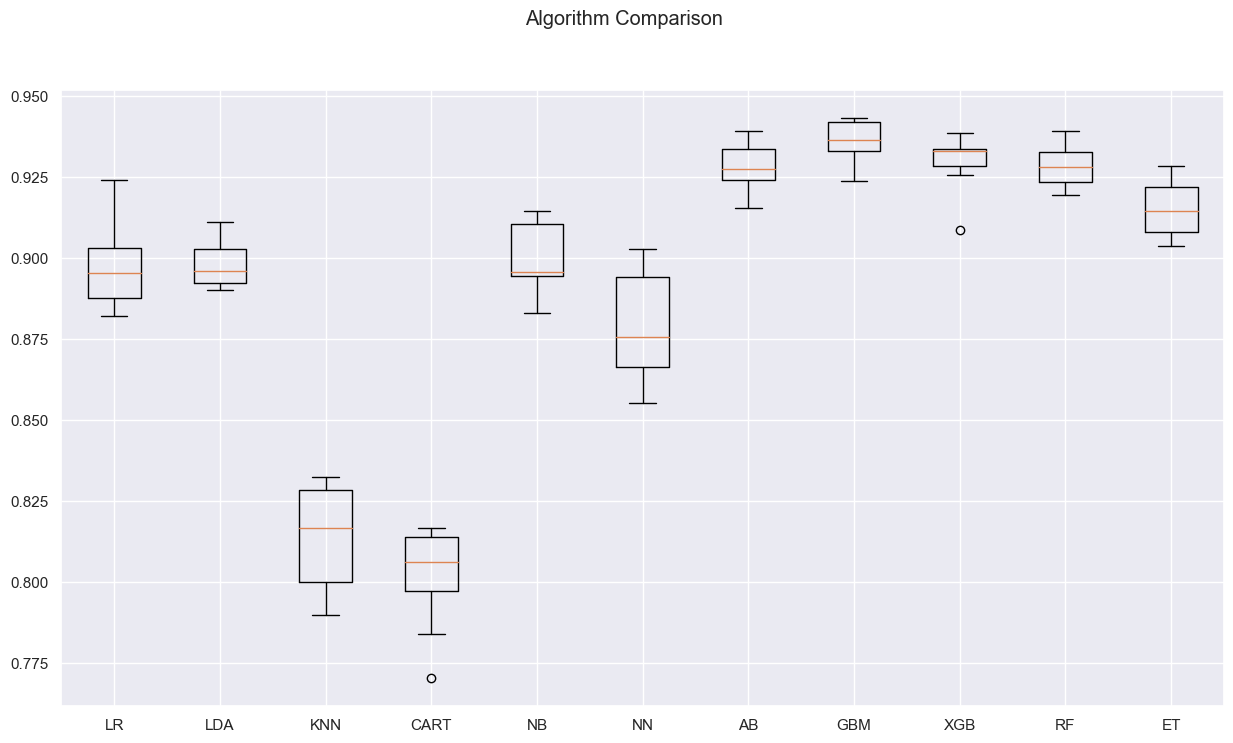

In [85]:
# compare algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

## Model Tuning and Grid Search

In [86]:
# Grid Search: GradientBoosting Tuning (with best model)
'''
n_estimators : int (default=100)
    The number of boosting stages to perform. 
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators. 
    The maximum depth limits the number of nodes in the tree. 
    Tune this parameter for best performance; the best value depends on the interaction of the input variables.

''' 
n_estimators = [20,180]
max_depth= [3,5]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)
model = GradientBoostingClassifier()
kfold = KFold(n_splits=num_folds, shuffle=True,random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.936878 using {'max_depth': 3, 'n_estimators': 180}
#4 0.927868 (0.007813) with: {'max_depth': 3, 'n_estimators': 20}
#1 0.936878 (0.005530) with: {'max_depth': 3, 'n_estimators': 180}
#3 0.931864 (0.006111) with: {'max_depth': 5, 'n_estimators': 20}
#2 0.934511 (0.007130) with: {'max_depth': 5, 'n_estimators': 180}


## Finalise the Model

In [87]:
# prepare model 
model = GradientBoostingClassifier(max_depth= 3, n_estimators= 180)
model.fit(X_train, Y_train)

GradientBoostingClassifier(n_estimators=180)

In [88]:
# estimate accuracy on validation set
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.845
[[ 823  250]
 [  91 1036]]
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1073
           1       0.81      0.92      0.86      1127

    accuracy                           0.84      2200
   macro avg       0.85      0.84      0.84      2200
weighted avg       0.85      0.84      0.84      2200



<Axes: xlabel='Predicted', ylabel='Actual'>

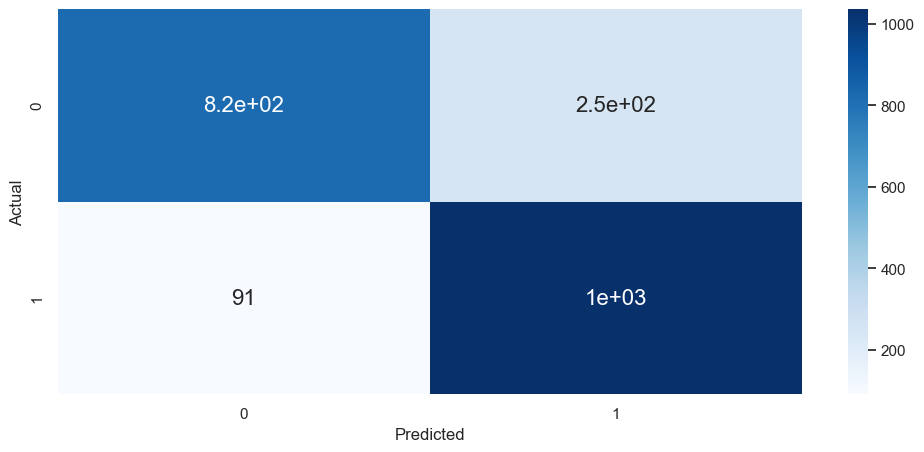

In [89]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font sizes

## Variable Intuition/Feature Importance

[1.54765830e-03 5.65887622e-03 1.08625990e-01 3.57317108e-02
 3.06246492e-02 7.63905063e-03 2.12575296e-02 6.37991221e-04
 1.34224552e-03 1.80907973e-03 1.93388934e-03 3.43161012e-03
 1.55744042e-03 1.92685237e-03 3.56666870e-03 3.19099477e-04
 7.37537044e-01 0.00000000e+00 8.26796876e-03 3.16865373e-03
 2.22820445e-03 2.37670307e-03 3.53396707e-03 1.50077818e-03
 1.37388600e-03 1.78278959e-03 5.91505753e-03 4.70460588e-03]


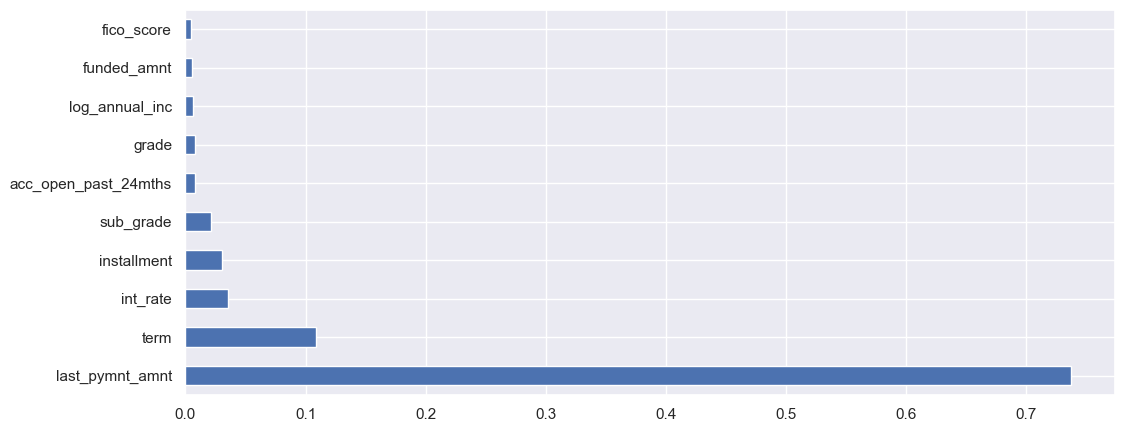

In [90]:
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
pyplot.show()